<h1>Ford GoBike Data Analysis project by Omar Ahmed </h1>

>Ford GoBike is a bike renting service in Bay Area, Calfornia. Users can rent the bicycles by picking them up from any of the docking stations and return to any one of the stations. Operates over 7000 bicycles from 540 stations spanning across San Francisco.

>Dataset contains information about individual rides made in San Francisco in February 2019.

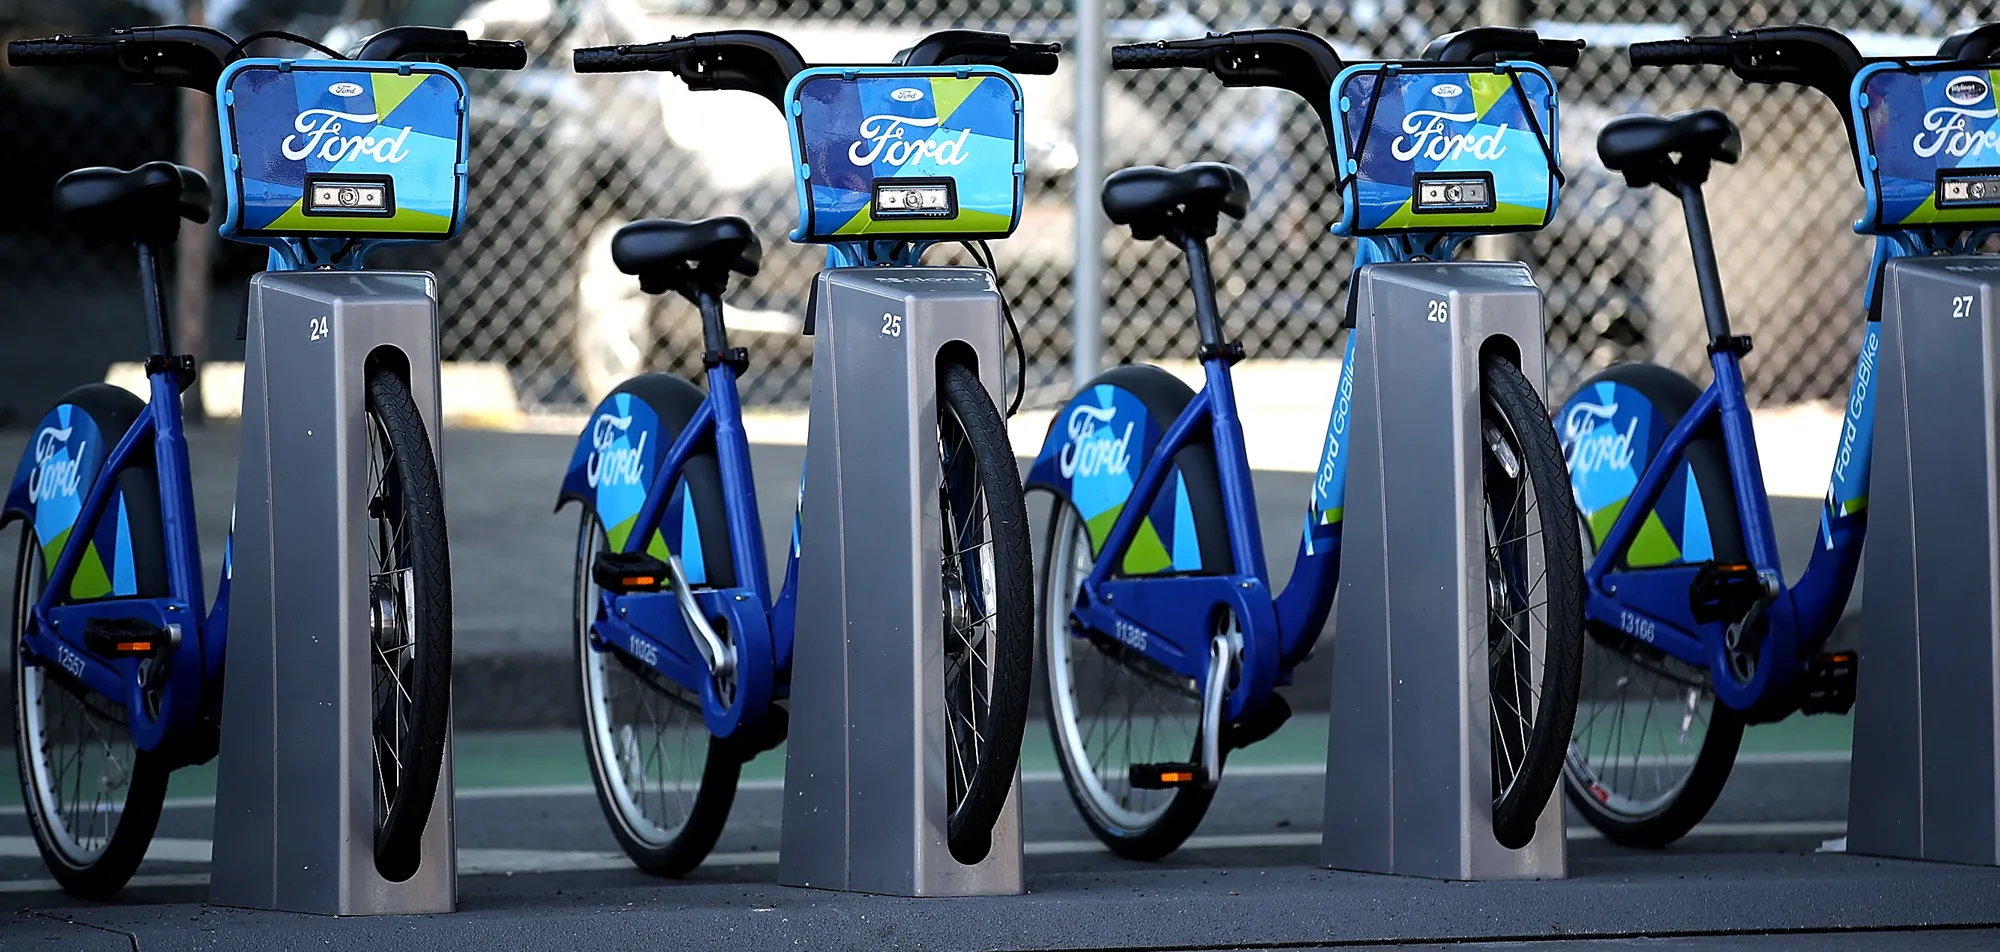

In [1]:
#importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import plotly.io as pio
pio.renderers.default = 'svg' 
#so I can upload visuals on github, if you want to see interaction change svg to notebook
pio.templates.default = 'simple_white'
from math import radians, sin, cos, sqrt, atan2
import warnings
warnings.filterwarnings("ignore")
sns.set_style('white')

In [2]:
#reading the data
df = pd.read_csv('fordgobike-tripdata.csv')
df.head()

duration_sec                start_time                  end_time  \
0         52185  2019-02-28 17:32:10.1450  2019-03-01 08:01:55.9750   
1         42521  2019-02-28 18:53:21.7890  2019-03-01 06:42:03.0560   
2         61854  2019-02-28 12:13:13.2180  2019-03-01 05:24:08.1460   
3         36490  2019-02-28 17:54:26.0100  2019-03-01 04:02:36.8420   
4          1585  2019-02-28 23:54:18.5490  2019-03-01 00:20:44.0740   

   start_station_id                                start_station_name  \
0              21.0  Montgomery St BART Station (Market St at 2nd St)   
1              23.0                     The Embarcadero at Steuart St   
2              86.0                           Market St at Dolores St   
3             375.0                           Grove St at Masonic Ave   
4               7.0                               Frank H Ogawa Plaza   

   start_station_latitude  start_station_longitude  end_station_id  \
0               37.789625              -122.400811            13.0   
1               37.791464              -122.391034            81.0   
2               37.769305              -122.426826             3.0   
3               37.774836              -122.446546            70.0   
4               37.804562              -122.271738           222.0   

                               end_station_name  end_station_latitude  \
0                Commercial St at Montgomery St             37.794231   
1                            Berry St at 4th St             37.775880   
2  Powell St BART Station (Market St at 4th St)             37.786375   
3                        Central Ave at Fell St             37.773311   
4                         10th Ave at E 15th St             37.792714   

   end_station_longitude  bike_id   user_type  member_birth_year  \
0            -122.402923     4902    Customer             1984.0   
1            -122.393170     2535    Customer                NaN   
2            -122.404904     5905    Customer             1972.0   
3            -122.444293     6638  Subscriber             1989.0   
4            -122.248780     4898  Subscriber             1974.0   

  member_gender bike_share_for_all_trip  
0          Male                      No  
1           NaN                      No  
2          Male                      No  
3         Other                      No  
4          Male                     Yes

In [3]:
#data informaion
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  float64
 14  memb

<h2> Data wrangling </h2>

In [4]:
#separate start time and end time into individual columns contain date and time Severally.
df['start_date'] = pd.to_datetime(df['start_time'],errors='ignore').dt.date
df['start_time'] = pd.to_datetime(df['start_time'],errors='ignore').dt.time
df['end_date'] = pd.to_datetime(df['end_time'],errors='ignore').dt.date
df['end_time'] = pd.to_datetime(df['end_time'],errors='ignore').dt.time

In [5]:
#extract day of the month
df['start_date'] =  pd.to_datetime(df['start_date'], format='%Y-%m-%d')
df['day'] = df['start_date'].apply(lambda x:x.day).astype(int)

In [6]:
#extract start hour
df['start_time'] = pd.to_datetime(df['start_time'],errors='ignore', format = "%H:%M:%S")
df['start_hour'] = df['start_time'].apply(lambda x:x.hour).astype(int)

In [7]:
#create a new column contians duration by hours instead of seconds
df['duration_hr'] = df['duration_sec'] / (60*60)

In [8]:
#delete columns which are not important in the analysis
df.drop(['start_station_id','end_station_id','bike_id'],axis=1,inplace=True)

In [9]:
#How old is too old to ride a bike? any value above age of 75 will be considerd as outlier and we will remove it.
df.query('member_birth_year<1948').shape[0]

524

In [10]:
df.drop(df.query('member_birth_year<1948').index,axis=0,inplace=True)

In [11]:
#fill the null values with the mean of the column
df.member_birth_year.fillna(df['member_birth_year'].mean()).astype(int)

0         1984
1         1984
2         1972
3         1989
4         1974
          ... 
183407    1996
183408    1984
183409    1990
183410    1988
183411    1989
Name: member_birth_year, Length: 182888, dtype: int32

In [12]:
#create a new column contians age of the user
df['age'] = 2023 - df['member_birth_year']

In [13]:
# Define age groups using if statements
def age_grouping(age):
    if 20 <= age <= 35:
        return '20-35 (Young Adult)'
    elif 36 <= age <= 60:
        return '36-60 (Adult)'
    else:
        return '60+ (Old)'

# Create a new column 'age_group' based on the age
df['age_group'] = df['age'].apply(age_grouping)

In [14]:
# Function to calculate distance using Haversine formula from latitude and longitude points
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in km
    R = 6371.0
    
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Distance in kilometers
    distance = R * c
    
    return distance
df['distance(KM)'] = df.apply(lambda row: haversine(row['start_station_latitude'],
                                               row['start_station_longitude'],
                                               row['end_station_latitude'],
                                               row['end_station_longitude']), axis=1)


In [15]:
#convert distance from kilometer to meter
df['distance(Meter)'] = df['distance(KM)'] * 1000

In [16]:
#calculate velocity
df['velocity(m/s)'] = df['distance(Meter)'] / df['duration_sec']

In [17]:
#drop any row contains null values
df.dropna(inplace = True)

In [18]:
#checking for duplicates
df.duplicated().sum()

0

In [19]:
#checking if the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174428 entries, 0 to 183411
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             174428 non-null  int64         
 1   start_time               174428 non-null  object        
 2   end_time                 174428 non-null  object        
 3   start_station_name       174428 non-null  object        
 4   start_station_latitude   174428 non-null  float64       
 5   start_station_longitude  174428 non-null  float64       
 6   end_station_name         174428 non-null  object        
 7   end_station_latitude     174428 non-null  float64       
 8   end_station_longitude    174428 non-null  float64       
 9   user_type                174428 non-null  object        
 10  member_birth_year        174428 non-null  float64       
 11  member_gender            174428 non-null  object        
 12  bike_share_for_all_tr

In [20]:
#take look at the statistics of our data
df.describe()

duration_sec  start_station_latitude  start_station_longitude  \
count  174428.000000           174428.000000            174428.000000   
mean      704.190801               37.771198              -122.351749   
min        61.000000               37.317298              -122.453704   
25%       323.000000               37.770407              -122.411901   
50%       511.000000               37.780774              -122.398279   
75%       789.000000               37.797320              -122.283093   
max     84548.000000               37.880222              -121.874119   
std      1643.988677                0.100421                 0.117757   

       end_station_latitude  end_station_longitude  member_birth_year  \
count         174428.000000          174428.000000      174428.000000   
mean              37.771394            -122.351324        1984.950318   
min               37.317298            -122.453704        1948.000000   
25%               37.770407            -122.411647        1980.000000   
50%               37.781010            -122.397437        1987.000000   
75%               37.797673            -122.286533        1992.000000   
max               37.880222            -121.874119        2001.000000   
std                0.100325               0.117319           9.733635   

                          start_date            day     start_hour  \
count                         174428  174428.000000  174428.000000   
mean   2019-02-15 07:23:00.081179648      15.307640      13.457753   
min              2019-02-01 00:00:00       1.000000       0.000000   
25%              2019-02-08 00:00:00       8.000000       9.000000   
50%              2019-02-15 00:00:00      15.000000      14.000000   
75%              2019-02-22 00:00:00      22.000000      17.000000   
max              2019-02-28 00:00:00      28.000000      23.000000   
std                              NaN       8.035123       4.736169   

         duration_hr            age   distance(KM)  distance(Meter)  \
count  174428.000000  174428.000000  174428.000000    174428.000000   
mean        0.195609      38.049682       1.690646      1690.646124   
min         0.016944      22.000000       0.000000         0.000000   
25%         0.089722      31.000000       0.910955       910.955336   
50%         0.141944      36.000000       1.429921      1429.920693   
75%         0.219167      43.000000       2.225102      2225.102293   
max        23.485556      75.000000      69.469241     69469.240682   
std         0.456664       9.733635       1.096347      1096.347321   

       velocity(m/s)  
count  174428.000000  
mean        3.011615  
min         0.000000  
25%         2.424906  
50%         3.076994  
75%         3.713430  
max        10.002770  
std         1.087144

## Univariate Exploration

> In this section, I will investigate distributions of individual variables.

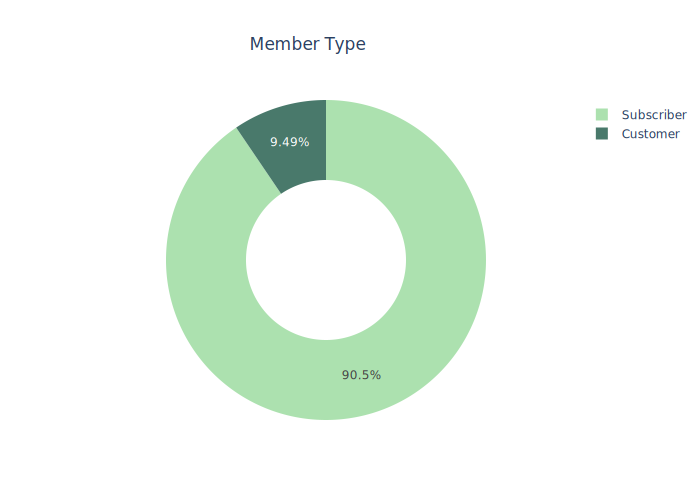

In [21]:
# Calculate the ratio of subscribers to customers
data = df['user_type'].value_counts() / df['user_type'].value_counts().sum()

# Create a Pie chart using Plotly
fig = px.pie(data, names=data.index, values=data, labels=data.index, 
             title='User Types', 
             template='plotly',  # You can choose a different template if you prefer
             hole=0.5,
             color = data.index,
             color_discrete_map={'Subscriber':'#ACE1AF','Customer':'#49796B'}
             )
fig.update_layout(title_text='Member Type', title_x=0.44)
# Show the figure
fig.show()

90.5% of the users are subscribers and 9.5%  are customers

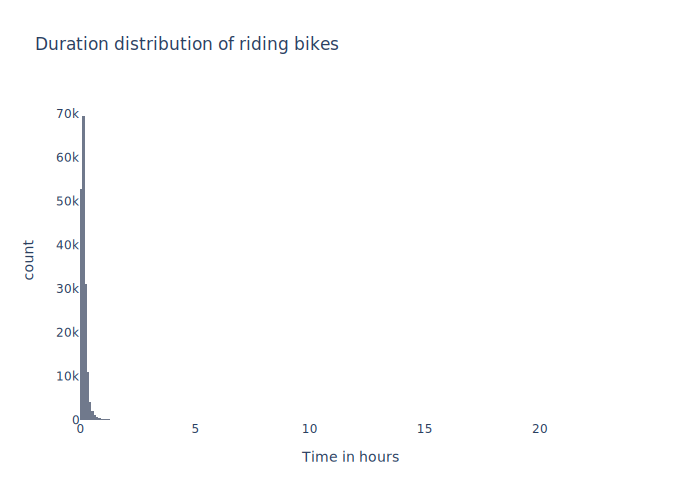

In [22]:
fig = px.histogram(df, x='duration_hr',
                   labels={'duration_hr': 'Time in hours', 'count': 'Number of riders'},
                   title='Duration distribution of riding bikes',
                   template='plotly', 
                   color_discrete_sequence=['#70798c'],
                   nbins=400)

# Set the background color to white
fig.update_layout(plot_bgcolor='white', paper_bgcolor='white')

# Show the figure
fig.show()

it seems we have some outliers because we have values more than half hour and we can not see them in the hist plot.


In [23]:
#users who drive for more than 30 minutes to all users
p_r = (df.query('duration_hr > 0.5').shape[0] / df.shape[0])*100
print("percentage of riders who ride for more than 30 minutes to all users",f'{p_r:.2f}',"%")

percentage of riders who ride for more than 30 minutes to all users 3.44 %


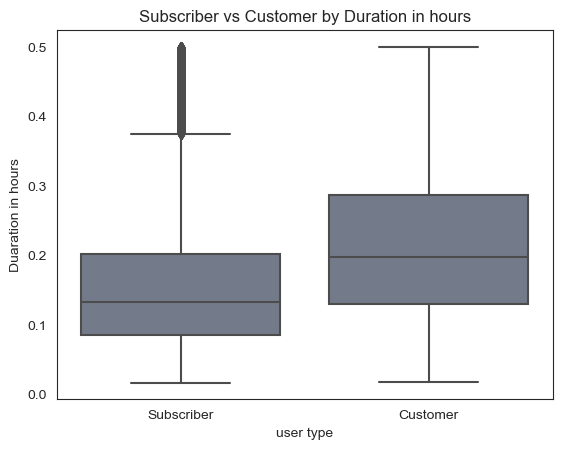

In [24]:
#get rid of outliers so that we can represent the data as boxplot with out problems to know which user types is riding for more time
sns.boxplot(x='user_type',y='duration_hr', data=df.query('duration_hr <= 0.5') ,color="#70798c")
# Add labels and a title
plt.xlabel("user type")
plt.ylabel("Duaration in hours")
plt.title("Subscriber vs Customer by Duration in hours")
plt.show()

The plot shows that customers on average ride for a longer time than subscribers. 

Customers riding duration is more than subscribers because the customers would normally be the tourists that would visit the city.

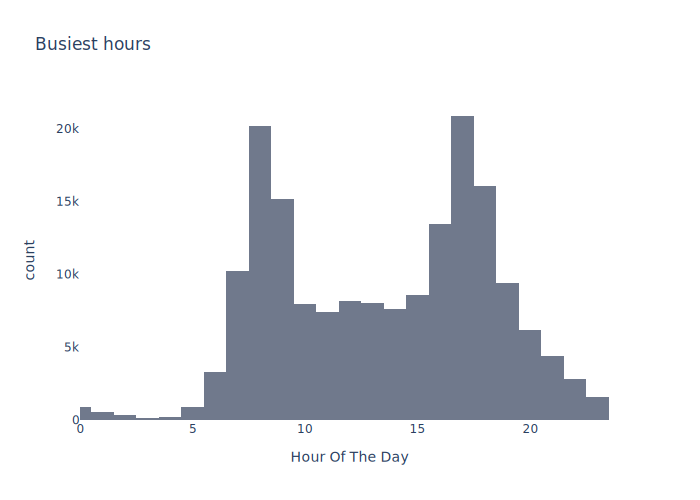

In [25]:
# Create a histogram using Plotly
fig = px.histogram(df, x='start_hour',
                   title='Busiest hours',
                   labels={'start_hour': 'Hour Of The Day', 'count': 'Number Of Rides'},
                   template='plotly',
                    color_discrete_sequence=['#70798c'])

# Set axis limits
fig.update_layout(plot_bgcolor='white', paper_bgcolor='white',xaxis=dict(range=[0, 24]))

# Show the figure
fig.show()

In [26]:
#Use numpy.histogram to calculate the previous histogram.
hist, edges = np.histogram(df['start_hour'], bins=np.arange(0,24,1), density=False)

point1 = 7
point2 = 19

# Find bin indices corresponding to the two points
index1 = np.searchsorted(edges, point1, side="right") - 1
index2 = np.searchsorted(edges, point2, side="right") - 1

# Sum histogram values between the two indices
sum_between_points = np.sum(hist[index1:index2 + 1])

# Normalize by the total number of data points
percentage_between_points = (sum_between_points / len(df)) * 100
print(f"{percentage_between_points:.2f}",'%')

87.82 %


from the bimodal distribution, we  can see the busiest hour of the day is 5 PM 

88% of users start riding between between 7 AM and 8 PM


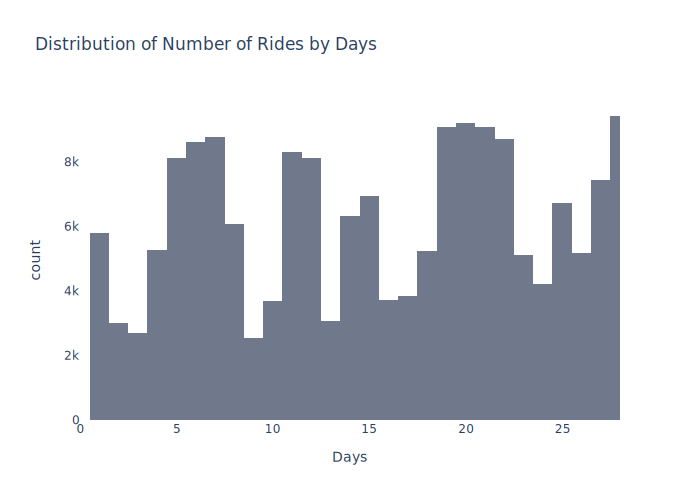

In [27]:
fig = px.histogram(df, x='day', 
             title='Distribution of Number of Rides by Days',
             labels={'day': 'Days', 'count': 'Number Of Rides'},
             template='plotly',
            color_discrete_sequence=['#70798c'])

# Set axis limits
fig.update_layout(plot_bgcolor='white', paper_bgcolor='white',xaxis=dict(range=[0, 28]))

# Show the figure
fig.show()

Saturday and Sunday are part of weekend in USA

There are not many riders on weekends days (2,3,9,10 and so on), most people ride on work days

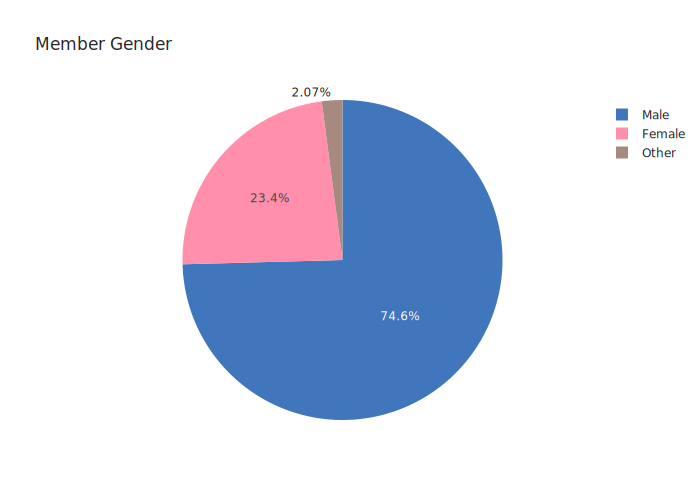

In [28]:
order = ['Male', 'Female', 'Other']
fig = px.pie(df, names='member_gender', title='Member Gender',
             category_orders={'member_gender': order},
             color_discrete_sequence=['#4076bb','#ff8fab' ,'#a78a7f' ])
fig.show()

member gender: 74.6% are males , 23.4 % females ,2.07% other

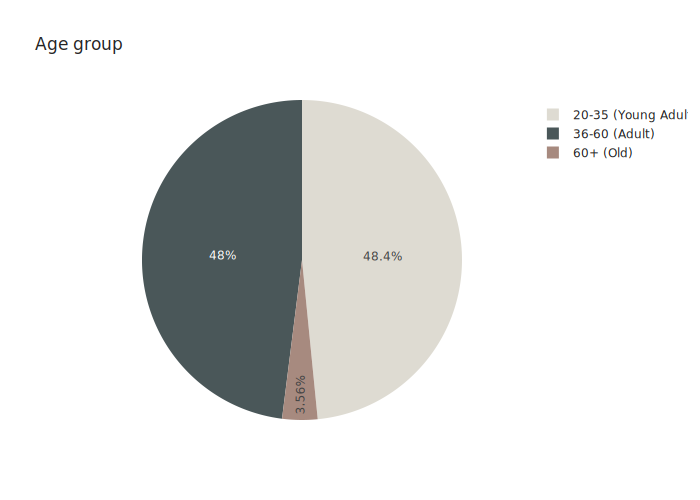

In [29]:
fig = px.pie(df, names='age_group', title='Age group',
             color_discrete_sequence=['#dedbd2','#4a5759' ,'#a78a7f' ])
fig.show()

Age Groups

20-35 (Young Adult)    48.4%

36-60 (Adult)          48%

60+ (Old)              3.5%

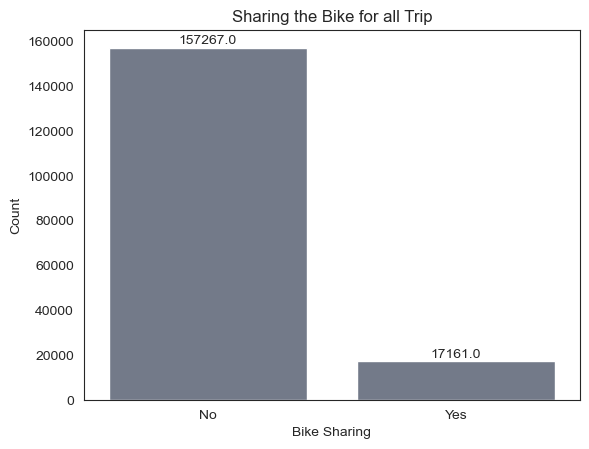

In [30]:
ax = sns.countplot(data=df,x='bike_share_for_all_trip',color='#70798c')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points',fontsize=10)
plt.xlabel('Bike Sharing')
plt.ylabel('Count')
plt.title('Sharing the Bike for all Trip')
plt.show()

90 % of members don't share their bike during trip.

## Bivariate Exploration

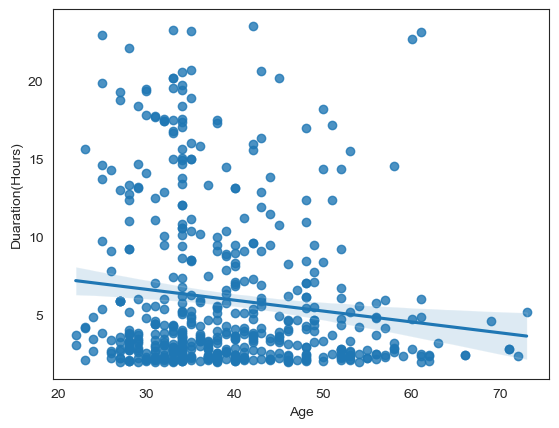

In [31]:
#active people who rides for more than two hours
active = df.query('duration_hr>2')
sns.regplot(data=active, x='age', y='duration_hr')
plt.xlabel('Age')
plt.ylabel('Duaration(Hours)')
plt.show()

There is a negative relationship between Age and riding duration.

percentage of active people who ride more than two hours decreases more older you get.

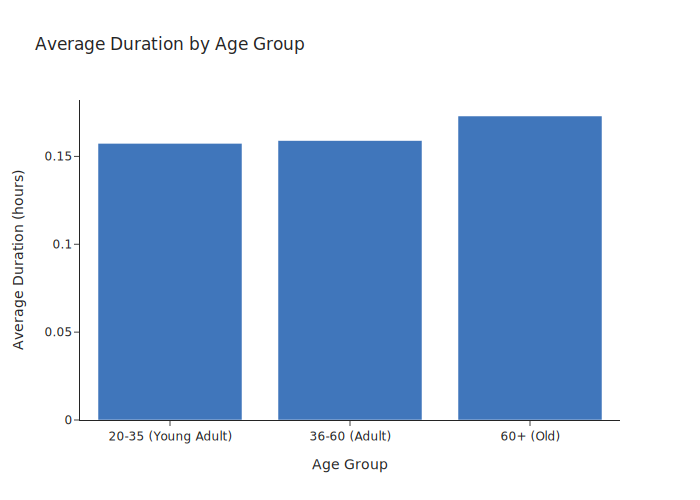

In [32]:
average_duration_by_age = df.query('duration_hr<0.5').groupby('age_group')['duration_hr'].mean().reset_index()
fig = px.bar(average_duration_by_age, x='age_group', y='duration_hr', title='Average Duration by Age Group',
             labels={'duration_hr': 'Average Duration (hours)', 'age_group': 'Age Group'},
             color_discrete_sequence=['#4076bb','#ff8fab' ,'#a78a7f' ])  

# Show the plot
fig.show()

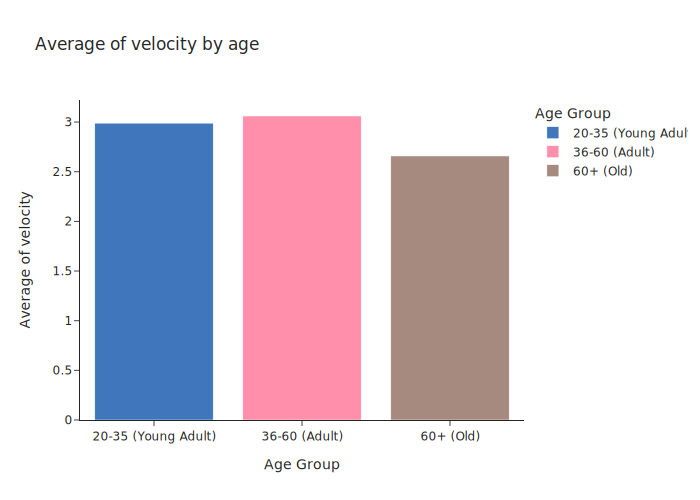

In [33]:
velocity_age = df.groupby('age_group')['velocity(m/s)'].mean()
fig = px.bar(velocity_age, color=velocity_age.index,y=velocity_age.values,title='Average of velocity by age',
            labels={'age_group': 'Age Group', 'y': 'Average of velocity'},
             color_discrete_sequence=['#4076bb','#ff8fab' ,'#a78a7f' ])

# Show the plot
fig.show()

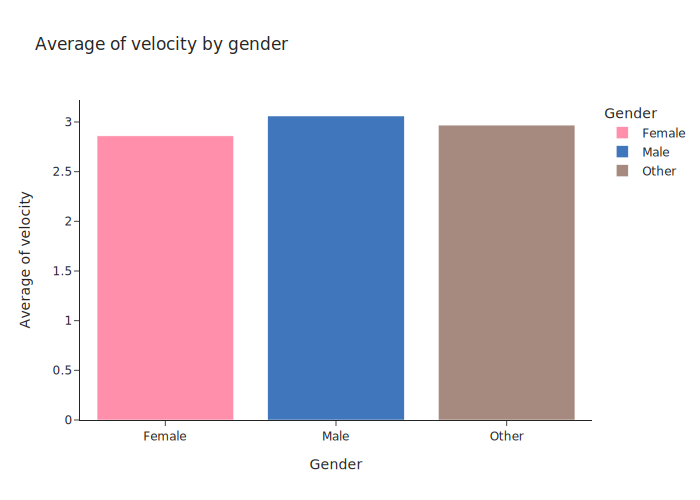

In [34]:
velocity_gender = df.groupby('member_gender')['velocity(m/s)'].mean()
fig = px.bar(velocity_gender, color=velocity_gender.index,
             y=velocity_gender.values,title='Average of velocity by gender',
            labels={'member_gender': 'Gender', 'y': 'Average of velocity'},
             color_discrete_sequence=['#ff8fab','#4076bb' ,'#a78a7f' ])

# Show the plot
fig.show()

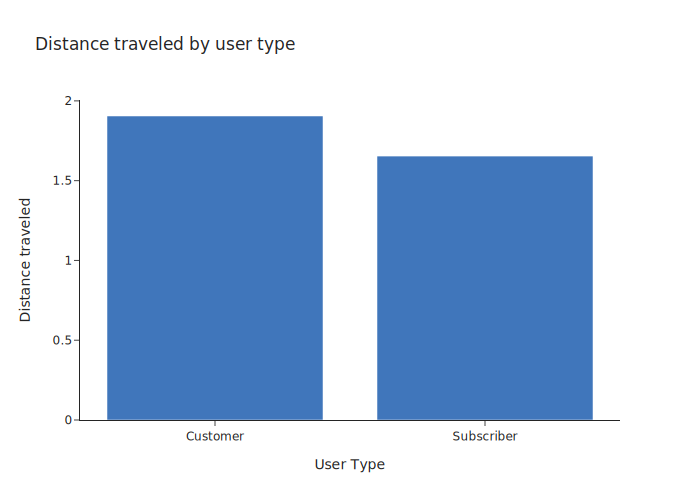

In [35]:
distance_member_type = df.query('duration_hr <= 0.5').groupby('user_type')['distance(KM)'].mean()
fig = px.bar(distance_member_type, x=distance_member_type.index,
             y=distance_member_type.values,title='Distance traveled by user type',
            labels={'user_type': 'User Type', 'y': 'Distance traveled'},
             color_discrete_sequence=['#4076bb','#ff8fab' ,'#a78a7f' ])

# Show the plot
fig.show()

Customers' riding duration is longer than subscribers because the customers would normally be the tourists that would visit the city.


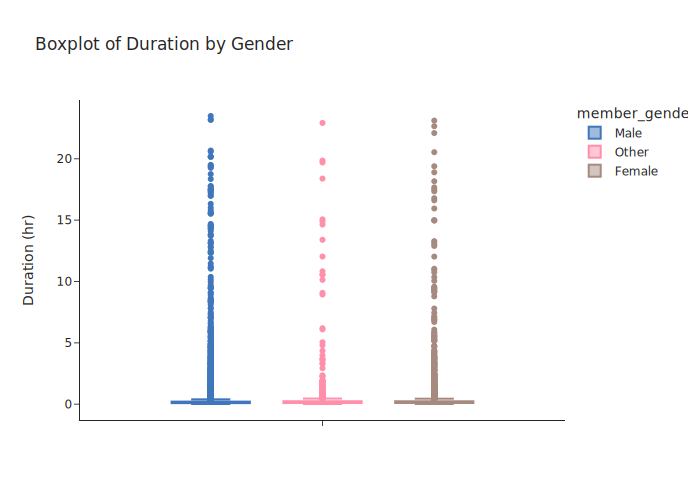

In [36]:
fig = px.box(df, color='member_gender', y='duration_hr',
             color_discrete_sequence=['#4076bb','#ff8fab' ,'#a78a7f' ],
             labels={'duration_hr': 'Duration (hr)'},
             title='Boxplot of Duration by Gender')

# Show the plot
fig.show()

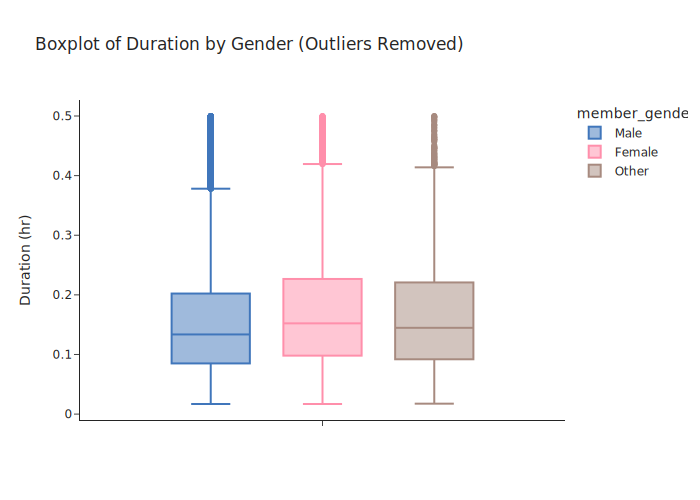

In [37]:
#To fix the box plot from all of these outliers we will get rid of it 
fig = px.box(df.query('duration_hr <= 0.5'), color='member_gender',
             y='duration_hr', color_discrete_sequence=['#4076bb','#ff8fab' ,'#a78a7f' ],
             labels={'duration_hr': 'Duration (hr)'},
             title='Boxplot of Duration by Gender (Outliers Removed)')

# Show the plot
fig.show()

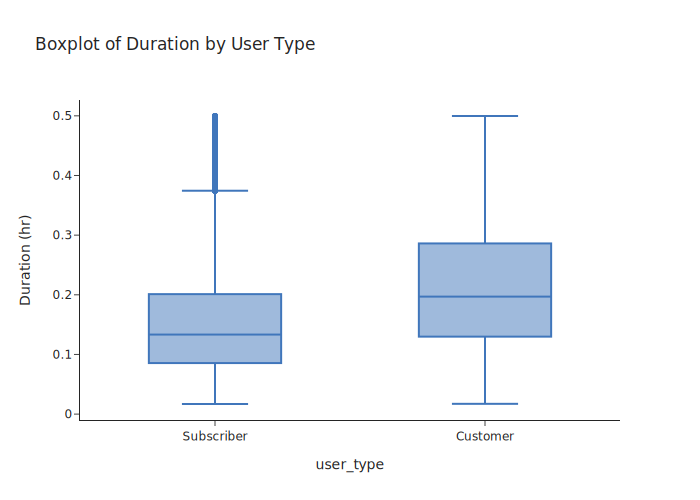

In [38]:
fig = px.box(df.query('duration_hr < 0.5'), x='user_type', y='duration_hr',
             labels={'duration_hr': 'Duration (hr)'}, title='Boxplot of Duration by User Type',
            color_discrete_sequence=['#4076bb','#ff8fab'])
fig.show()

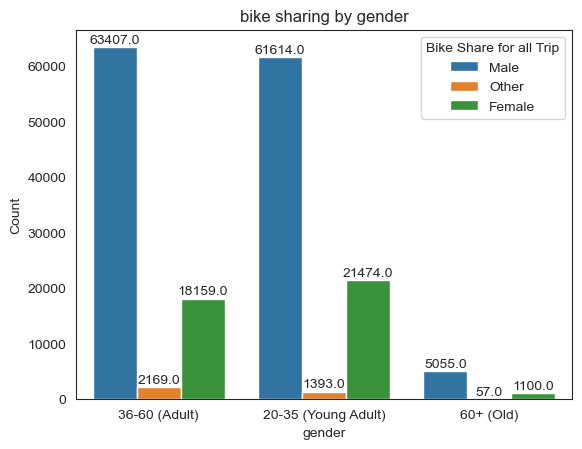

In [39]:
ax = sns.countplot(data=df,x='age_group',hue='member_gender')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points',fontsize=10)
plt.xlabel('gender')
plt.ylabel('Count')
plt.legend(title='Bike Share for all Trip')
plt.title('bike sharing by gender')
plt.show()

we can consider that A bicycle rides 6 m/s or more , the person is in a hurry or he is doing cardio.

we will filter the data for those people and see.

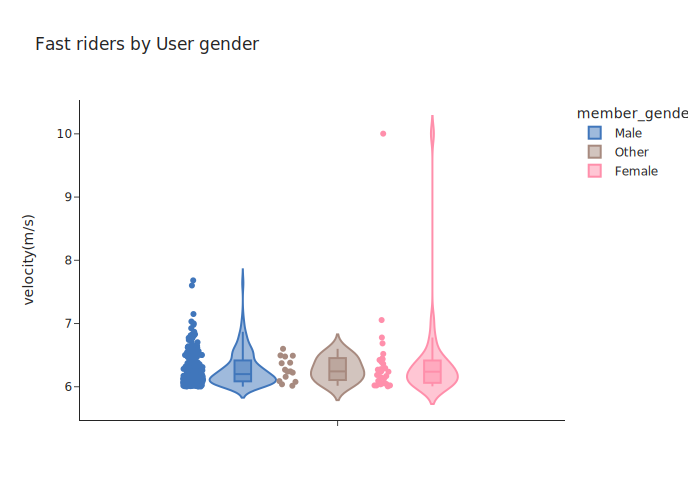

In [40]:
fig = px.violin(df[df['velocity(m/s)']>=6], color='member_gender', y='velocity(m/s)',
               title='Fast riders by User gender ',
                color_discrete_sequence=['#4076bb','#a78a7f' , '#ff8fab'],
                points="all",box=True)
fig.show()

The percentage of people to all people in our dataset is 0.16%, only 275 member.

We can see the majority of those people are males.

Interestingly the fastest rider in our data set is a female with a velocity = 10 m/s!

## Multivariate Exploration

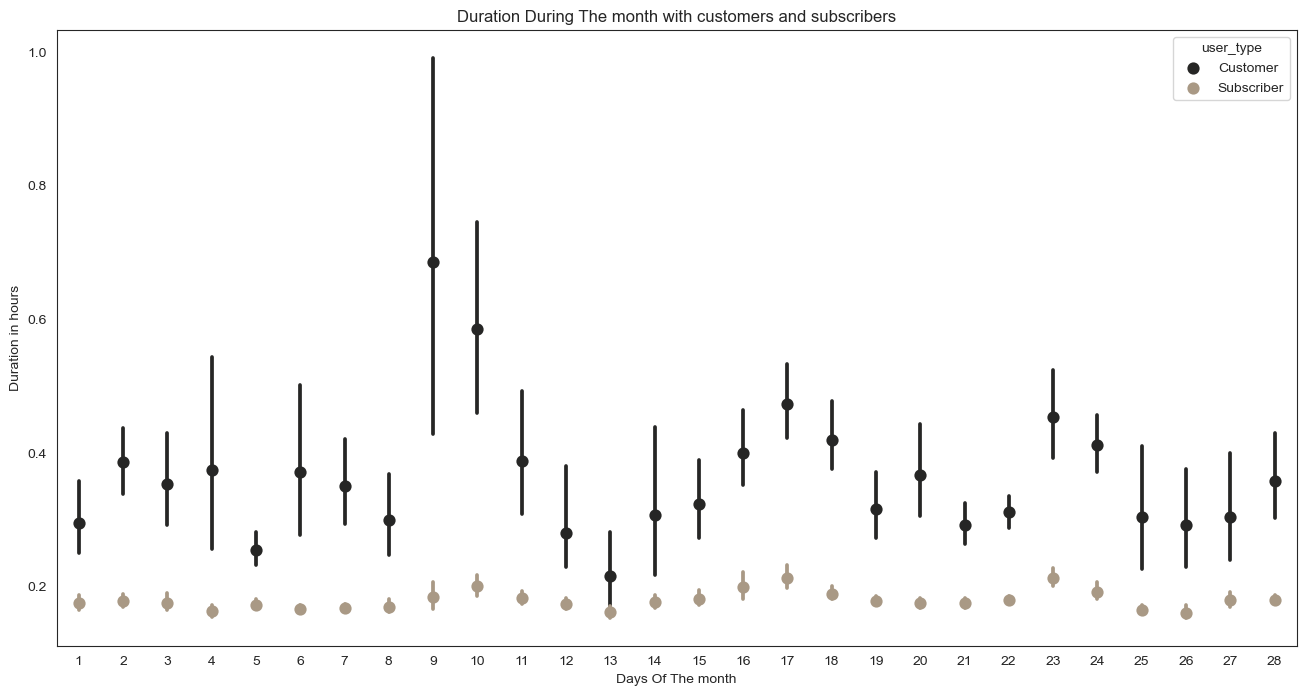

In [41]:
#Distribution of duration for a trip by days and user types
plt.figure(figsize=(16,8));
sns.pointplot(data=df, x='day' , y='duration_hr',
              hue='user_type',linestyles ="",color ="#a99985")
plt.xlabel('Days Of The month')
plt.ylabel('Duration in hours')
plt.title('Duration During The month with customers and subscribers')
plt.show()

the plot shows us that customers on average take a longer trip than subscribers every day of the month. 

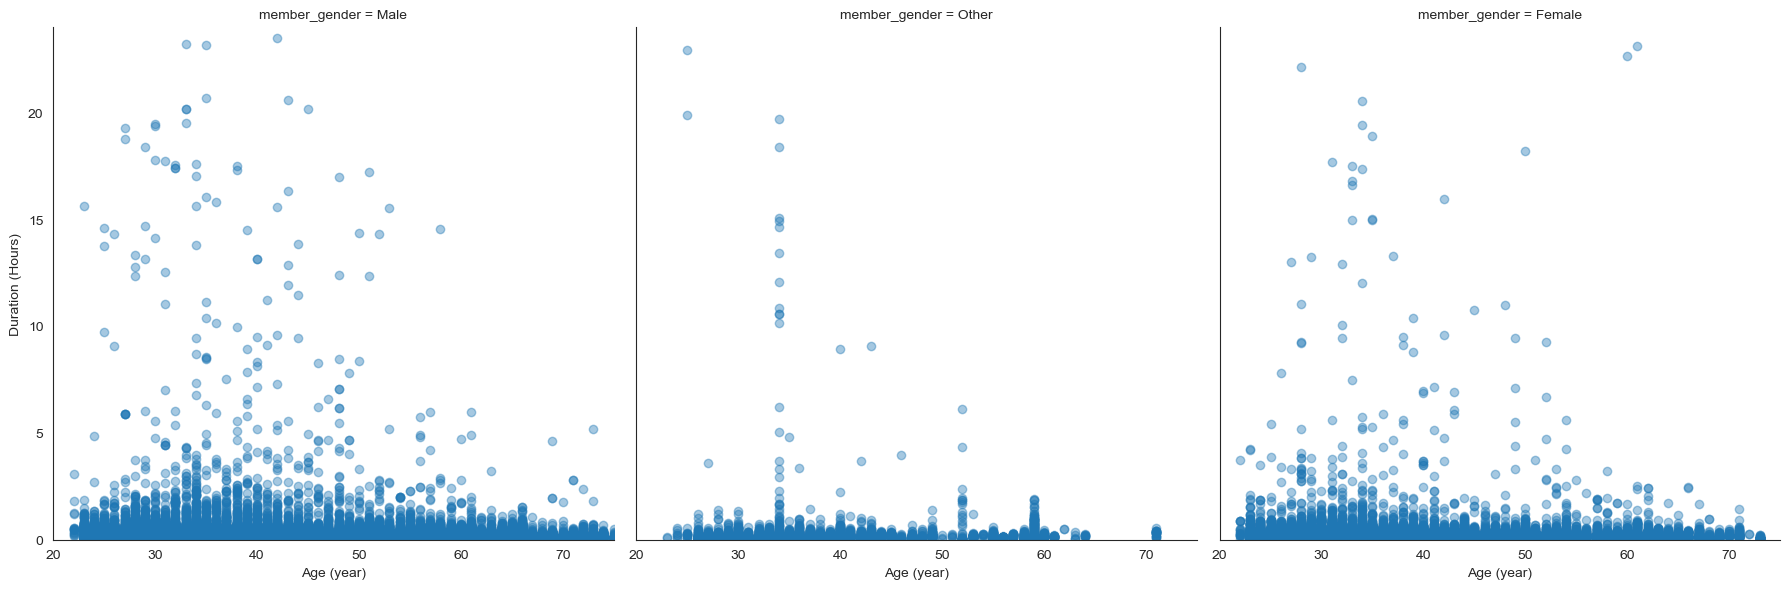

In [42]:
grid = sns.FacetGrid(data = df, col = 'member_gender', col_wrap = 3,height=6, xlim = [20, 75], ylim = [0, 24])
grid.map(plt.scatter, 'age', 'duration_hr', alpha=0.4)
grid.set_xlabels('Age (year)')
grid.set_ylabels('Duration (Hours)')
plt.show()

<h1> Conclusion </h1>

• 90.5% of the users are subscribers and 9.5%  are customers.

• percentage of all riders who ride for more than 30 minutes to all users 2.68 %

• Customers' riding duration is longer than subscribers because the customers would normally be the tourists that would visit the city.

• The busiest hours of the day is 5 PM, 88% of all members start riding between 7 AM to 8 PM.

• There are fewer riders on weekend days (2,3,9,10 and so on), the majority of people ride on work days.

• 75% of members are males, females = 23% ,others =2%

• 20-35 (Young Adult) represent 48.4% of our dataset, 36-60 (Adult) 48%, 60+ (Old) 3.6%

• 90 % of members don't share their bike during the trip.

• The percentage of active people who ride for more than two hours decreases the older you get.

• Adults between (36-60) ride slightly faster than other people on average.

• The percentage of people who rides at valocity = 6m/s to all people in our dataset is 0.16%, only 275 member.

• Interestingly! the fastest rider in our data set is a female with a velocity=10 m/s!

<h1> Note:</h1>
The velocity column can never be calculated with high accuracy by the method I have done because the distance is a displacement (Displacement is the straight line distance in a particular direction.)

the actual distance will be much higher than displacement because of (roads, buildings, etc..), but I did this method to get any estimation about the speed of members.